# Analyzing the qPCR result from 7-12-21
made from T-cell RNA. Extracted from same cells used for the smallseq miRNA sequencing library. 
Cells are: T0, T1, T2, T17 and Treg (1-5), and negative control, without RT, (6-10)

Genes are: 
* TBX21 (Th1)
* RORy (Th17)
* FOXP3 (Treg) 
* GATA3 (Th2)
* IL4
* IL17a
* GAPDH
* ATP5F1

In [177]:
import pandas as pd
from datar.all import *
from plotnine import *
import numpy as np 

In [178]:
pcr = pd.read_csv('qPCR 7-12-21.tsv', delimiter='\t')

pcr = (pcr >>
 separate(f.Well, ['gene', 'cell'], sep=r'(\d+)'))

In [179]:
pcr = (pcr >>
 mutate(gene = case_when(f.gene == 'A', 'TBX21',
                        f.gene == 'B', 'RORy',
                        f.gene == 'C', 'FOXP3',
                        f.gene == 'D', 'GATA3',
                        f.gene == 'E', 'IL4',
                        f.gene == 'F', 'IL17',
                        f.gene == 'G', 'GAPDH',
                        f.gene == 'H', 'ATP5F1')) >>
 mutate(cell = case_when(f.cell == '01', 'Th0',
                        f.cell == '02', 'Th1',
                        f.cell == '03', 'Th2',
                        f.cell == '04', 'Th17',
                        f.cell == '05', 'Treg',
                        f.cell == '06', 'Th0_neg',
                        f.cell == '07', 'Th1_neg',
                        f.cell == '08', 'Th2_neg',
                        f.cell == '09', 'Th17_neg',
                        f.cell == '10', 'Treg_neg')) >>
 mutate(Cq = f.Cq.str.replace(',', '.')) >>
 replace_na(40) >>
 mutate(Cq = as_float(f.Cq)) >>
 select(f.cell, f.gene, f.Cq)
)

housekeep = (pcr >> filter(f.gene == 'GAPDH') >> pull(f.Cq)).to_list() * 8
pcr['housekeep'] = housekeep

pcr['delta_ct'] = pcr['Cq'] - pcr['housekeep']

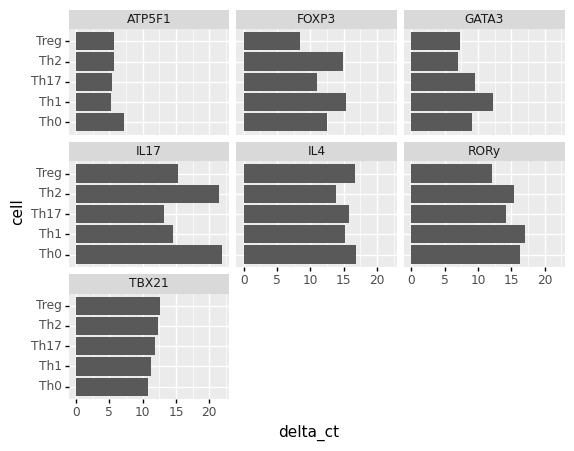

<ggplot: (382691708)>

In [180]:
(pcr >> 
 filter(~endswith(f.cell, '_neg')) >>
 filter(f.gene != 'GAPDH') >>
 ggplot(aes('cell', 'delta_ct')) + 
 geom_col() + 
 facet_wrap('gene') + 
 coord_flip()
)

## Compare everything to Th0? 
So that every cells $\Delta$Ct is subtracted by T0H $\Delta$Ct

In [181]:

def deltadelta(df: pd.DataFrame, gene: str, reference: str, housekeeping: str = 'GAPDH' ) -> pd.DataFrame:

    '''Calculates delta delta ct for a gene and a reference cell. Returns a new dataframe and a figure. '''
    
    reference_value = df >> filter(f.gene == gene, f.cell == reference) >> pull(f.delta_ct) 
    reference_value = float(reference_value)

    dd_df = (df >> 
             filter(f.gene == gene, ~endswith(f.cell, '_neg')) >>
             mutate(deltadelta_ct = f.delta_ct - reference_value) >>
             #get rid of the reference value since its only 0
             filter(f.deltadelta_ct != 0) >>
             mutate(foldchange = 2 ** -(f.deltadelta_ct)) >>
             mutate(log2change = -f.deltadelta_ct)) 
    
    fig = (dd_df >> 
     mutate(cell = fct_reorder(f.cell, f.log2change)) >>
     ggplot(aes('cell', 'log2change')) + 
     geom_col(fill='lightblue') +
     coord_flip() + 
     geom_hline(yintercept=0, linetype='dashed', color='darkblue') +
     theme_seaborn() +
     labs(title=f'Log2 change of {gene} compared to {reference} (\u0394\u0394C method)',
          x='',
          y='Log2 change')
    )
    
    return fig, dd_df
    

# FOXP3
### FOXP3 is supposed to be upregulated in Treg cells

In [168]:
fig, _ = deltadelta(pcr, 'FOXP3', 'Th0')
fig.save('FOXP3.png')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: FOXP3.png


# GATA3
### Supposed to be upregulated in Th2 cells 


In [169]:
gata3, _ = deltadelta(pcr, 'GATA3', 'Th0')
gata3.save('GATA3.png')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: GATA3.png


# RORy
### Supposed to be upregulated in Th17. Here, it seems like its mostly upregulated in Tregs.

In [182]:
fig, _ = deltadelta(pcr, 'RORy', 'Th0')
fig.save('RORy.pdf')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: RORy.pdf


# TBX21
### Supposed to be upregulated in Th1. Here it seems like it is slightly less compared to Th0. 

In [183]:
fig, _ = deltadelta(pcr, 'TBX21', 'Th0')
fig.save('TBX.pdf')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: TBX.pdf


# IL4

In [184]:
fig, _ = deltadelta(pcr, 'IL4', 'Th0')
fig.save('IL4.pdf')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: IL4.pdf


# IL17a

In [185]:
fig, _ = deltadelta(pcr, 'IL17', 'Th0')
fig.save('IL17a.pdf')

/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/williamrosenbaum/opt/miniconda3/envs/smallseq/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: IL17a.pdf
